In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString, Point, MultiPoint
import networkx as nx
import geonetworkx as gnx
import google_conf
import numpy as np

In [4]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

In [5]:
provinces = gpd.read_file("../data/roman_province_boundaries.json") # province file from "https://edh.ub.uni-heidelberg.de/data/download/roman_province_boundaries.json"
# however, there are invalid geometries... the following solution is based on advice from ChatGPT...
invalid_geometries = provinces[~provinces.geometry.is_valid]
# Make invalid geometries valid by buffering with a distance of 0
provinces.loc[~provinces.geometry.is_valid, 'geometry'] = invalid_geometries.buffer(0)
provinces = provinces.to_crs(3035)
# provinces.to_file("../data/provinces_valid.geojson")
#provinces = gpd.read_file("../data/provinces_valid.geojson")
provinces = provinces.to_crs("EPSG:4326")#
len(provinces)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/pygeos/constructive.py:175: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


61

In [6]:
provinces_unary_union = provinces.unary_union

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/pygeos/set_operations.py:388: RuntimeWarning: invalid value encountered in unary_union
  result = lib.unary_union(collections, **kwargs)


In [7]:
origo_geo = gpd.read_parquet("../data/origo_geo.parquet")
origo_geo = origo_geo.set_geometry("edh_point")
origo_geo.crs = "EPSG:4326"

In [8]:
origo_geo = gpd.sjoin(origo_geo, provinces, how="left")
origo_geo.rename(columns={"province" : "province_dest", "index_right" : "dest_index"}, inplace=True)

In [9]:
origo_geo = origo_geo.set_geometry("origo_point")
origo_geo.crs = "EPSG:4326"
origo_geo = gpd.sjoin(origo_geo, provinces, how="left")
origo_geo.rename(columns={"province" : "province_source", "index_right" : "source_index"}, inplace=True)

In [10]:
origo_geo

,id,hd_nr,origo,origo_clean,pleiades_id,pleiades_title_list,pleiades_Latitude,pleiades_Longitude,pleiades_title,Certainty,...,1BCE,1CE,2CE,3CE,4CE,5CE,dest_index,province_dest,source_index,province_source
0,HD075902/1,HD075902,cives(!) (= civis) Nervius+,() (= ) Nervius,109199.0,None,50.777494,4.084768,Nervii,certain,...,False,False,True,True,False,False,28.0,Germania Inferior,24.0,Belgica
1,HD081444/1,HD081444,natione(?)Pannonius,()Pannonius,992076.0,None,47.500000,12.500000,Pannoniae,uncertain (name could be interpreted differently),...,False,False,True,True,False,False,20.0,Britannia,42.0,Noricum
2,HD056833/3,HD056833,cives(= civis) Convena*,(= ) Convena,246357.0,None,42.966682,0.269919,Convenae,certain,...,False,False,True,False,False,False,41.0,Hispania Citerior,26.0,Aquitania
3,HD018231/1,HD018231,cives(= civis) Veliocassinius,(= ) Veliocassinius,109412.0,None,49.364001,0.831097,Veliocasses,certain,...,False,False,True,True,False,False,28.0,Germania Inferior,27.0,Lugdunensis
4,HD010286/1,HD010286,natione+* [---] Aelia [---],[---] Aelia [---],197389.0,None,45.560018,18.675749,Mursa,uncertain (name could be interpreted differently),...,False,False,True,False,False,False,6.0,Latium et Campania (Regio I),43.0,Pannonia Inferior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,HD037345/1,HD037345,natione Zoela!,Zoela,236724.0,None,41.717349,-6.628006,Zoelae,certain,...,False,True,False,False,False,False,43.0,Pannonia Inferior,41.0,Hispania Citerior
2589,HD056506/2,HD056506,Ἐφέσιος,Ἐφέσιος,599612.0,None,37.940762,27.340307,Ephesus/Arsinoe(ia),certain,...,True,False,False,False,False,False,0.0,Achaia,19.0,Asia
2607,HD025474/5,HD025474,Μιλήσιος,Μιλήσιος,599799.0,None,37.522905,27.278317,Miletus,certain,...,False,False,True,False,False,False,46.0,Aegyptus,19.0,Asia
2637,HD008584/6,HD008584,natione verna,None,167964.0,None,45.776152,5.281057,Vernas,wild guess,...,True,False,False,False,False,False,6.0,Latium et Campania (Regio I),25.0,Narbonensis


In [11]:
centroid_series = provinces.centroid

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_9480/1802002792.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_series = provinces.centroid


In [12]:
pronvinces_edges_weighted = origo_geo.groupby(["source_index", "dest_index"], as_index=False).size()
pronvinces_edges_weighted.rename(columns={"size" : "weight"}, inplace=True)
pronvinces_edges_weighted

,source_index,dest_index,weight
0,0.0,0.0,1
1,0.0,6.0,2
2,0.0,20.0,4
3,0.0,23.0,1
4,0.0,24.0,1
...,...,...,...
586,60.0,56.0,3
587,60.0,57.0,1
588,60.0,58.0,3
589,60.0,59.0,1


In [13]:
origo_geo[(origo_geo["source_index"]==0) & (origo_geo["dest_index"]==20)]

,id,hd_nr,origo,origo_clean,pleiades_id,pleiades_title_list,pleiades_Latitude,pleiades_Longitude,pleiades_title,Certainty,...,1BCE,1CE,2CE,3CE,4CE,5CE,dest_index,province_dest,source_index,province_source
343,HD001389/1,HD001389,natus* Athenis*,Athenis,579885.0,None,37.972454,23.726268,Athenae,uncertain (another good variant exists),...,False,True,False,False,False,False,20.0,Britannia,0.0,Achaia
1078,HD069555/1,HD069555,natione Grecus,Grecus,1001896.0,None,37.500000,22.500000,Hellas,uncertain (name could be interpreted differently),...,False,False,True,True,False,False,20.0,Britannia,0.0,Achaia
1079,HD070191/1,HD070191,civis Grecus,Grecus,1001896.0,None,37.500000,22.500000,Hellas,uncertain (name could be interpreted differently),...,False,False,False,False,True,False,20.0,Britannia,0.0,Achaia
1415,HD069852/1,HD069852,domo Melitenis,Melitenis,582863.0,None,37.979531,23.718407,Melite,uncertain (another good variant exists),...,False,False,False,True,False,False,20.0,Britannia,0.0,Achaia


In [14]:
origo_geo.columns

Index(['id', 'hd_nr', 'origo', 'origo_clean', 'pleiades_id',
       'pleiades_title_list', 'pleiades_Latitude', 'pleiades_Longitude',
       'pleiades_title', 'Certainty', 'edh_point', 'origo_point', 'origo_line',
       'random_date', 'not_before', 'not_after', '1BCE', '1CE', '2CE', '3CE',
       '4CE', '5CE', 'dest_index', 'province_dest', 'source_index',
       'province_source'],
      dtype='object')

In [26]:
origo_geo.to_parquet("../data/origo_geo_provinces.parquet")

# make a directed geo graph of provinces, with nodes located in their centroids


In [15]:
G = gnx.GeoDiGraph()
G.add_nodes_from_gdf(provinces)

# node positions
centroid_series_pos = centroid_series.apply(lambda point: (point.x, point.y))
pos_dict = dict(zip(range(len(centroid_series_pos)), centroid_series_pos.tolist()))

In [16]:
centuries_strs = ['1BCE', '1CE', '2CE', '3CE', '4CE', '5CE']

In [17]:
cent_graphs = {}
for cent in centuries_strs:
    G_cent = G.copy()
    provinces_edges_weighted = origo_geo[origo_geo[cent]].groupby(["source_index", "dest_index"], as_index=False).size()
    provinces_edges_weighted.rename(columns={"size" : "weight"}, inplace=True)
    provinces_edges_weighted_tuples = [tuple(el) for el in provinces_edges_weighted.values.tolist()]
    G_cent.add_weighted_edges_from(provinces_edges_weighted_tuples)
    G_cent.remove_edges_from(nx.selfloop_edges(G_cent))
    cent_graphs[cent] = G_cent

In [18]:
cent_graphs["2CE"].edges(data=True)

OutEdgeDataView([(0, 6.0, {'weight': 2.0}), (0, 20.0, {'weight': 1.0}), (0, 24.0, {'weight': 1.0}), (0, 29.0, {'weight': 1.0}), (0, 30.0, {'weight': 4.0}), (0, 43.0, {'weight': 1.0}), (0, 56.0, {'weight': 1.0}), (0, 58.0, {'weight': 1.0}), (0, 59.0, {'weight': 1.0}), (0, 60.0, {'weight': 2.0}), (1, 23.0, {'weight': 1.0}), (1, 58.0, {'weight': 1.0}), (3, 6.0, {'weight': 2.0}), (3, 28.0, {'weight': 2.0}), (3, 58.0, {'weight': 1.0}), (3, 59.0, {'weight': 2.0}), (3, 60.0, {'weight': 2.0}), (4, 6.0, {'weight': 2.0}), (4, 20.0, {'weight': 1.0}), (4, 23.0, {'weight': 1.0}), (4, 28.0, {'weight': 2.0}), (4, 42.0, {'weight': 1.0}), (4, 44.0, {'weight': 2.0}), (4, 58.0, {'weight': 2.0}), (4, 60.0, {'weight': 2.0}), (5, 6.0, {'weight': 1.0}), (5, 44.0, {'weight': 1.0}), (5, 60.0, {'weight': 1.0}), (6, 2.0, {'weight': 1.0}), (6, 12.0, {'weight': 1.0}), (6, 23.0, {'weight': 4.0}), (6, 28.0, {'weight': 1.0}), (6, 30.0, {'weight': 1.0}), (6, 39.0, {'weight': 2.0}), (6, 42.0, {'weight': 1.0}), (6, 43.0

In [19]:
for key in centuries_strs:
    print(len(cent_graphs[key].edges))

42
326
404
234
35
14


In [20]:
fig, axs = plt.subplots(3,2, figsize=(5.2, 6), dpi=600, tight_layout=True)
for cent, ax in zip(centuries_strs, axs.ravel()):
    G_cent = cent_graphs[cent]
    # getting colormap values for provinces
    indegrees_weighted = [G_cent.in_degree(node, weight="weight") for node in G_cent.nodes]
    cmap = plt.colormaps.get_cmap("Greens")
    norm = plt.Normalize(min(indegrees_weighted), max(indegrees_weighted))
    normalized_values = norm(indegrees_weighted)
    provinces_colormap_values = cmap(normalized_values)

    Gun = gnx.GeoGraph()
    Gun.add_nodes_from_gdf(provinces)
    for u, v, weight in G_cent.edges(data='weight', default=1):
        if Gun.has_edge(u, v):
            Gun[u][v]['weight'] += weight
        elif Gun.has_edge(v, u):
            Gun[v][u]['weight'] += weight
        else:
            Gun.add_edge(u, v, weight=weight)
    # getting colormap values for edges
    edge_weights_sqrt = [np.sqrt(w) for w in nx.get_edge_attributes(Gun, "weight").values()]
    cmap = plt.colormaps.get_cmap("BuGn")
    norm = plt.Normalize(min(edge_weights_sqrt) - max(edge_weights_sqrt), max(edge_weights_sqrt))
    normalized_edge_weights = norm(edge_weights_sqrt)
    edges_colormap_values = cmap(normalized_edge_weights)
    # getting edge widhts
    edge_sizes = [np.sqrt(w) / 5  for w in nx.get_edge_attributes(Gun, "weight").values()]

    # draw provinces

    provinces.plot(ax=ax, color=provinces_colormap_values, edgecolor="darkgray", linewidth=0.3)

    # draw edges
    nx.draw_networkx_edges(Gun,
                           pos=pos_dict,
                           node_size=1,
                           alpha=0.7,
                           width= edge_sizes,
                           #width=0.5,
                           style="solid",
                           edge_color=edges_colormap_values,
                           arrows=True,
                           connectionstyle="arc3,rad=0.3",
                           ax=ax)
    ax.set_axis_off()
    ax.set_title(cent)

In [23]:
fig.savefig("../figures/Fig08_networks_provinces_by_cent_600dpi.png")

In [24]:
fig.savefig("../figures/Fig08_networks_provinces_by_cent_600dpi.tiff")


# Developing network figures...

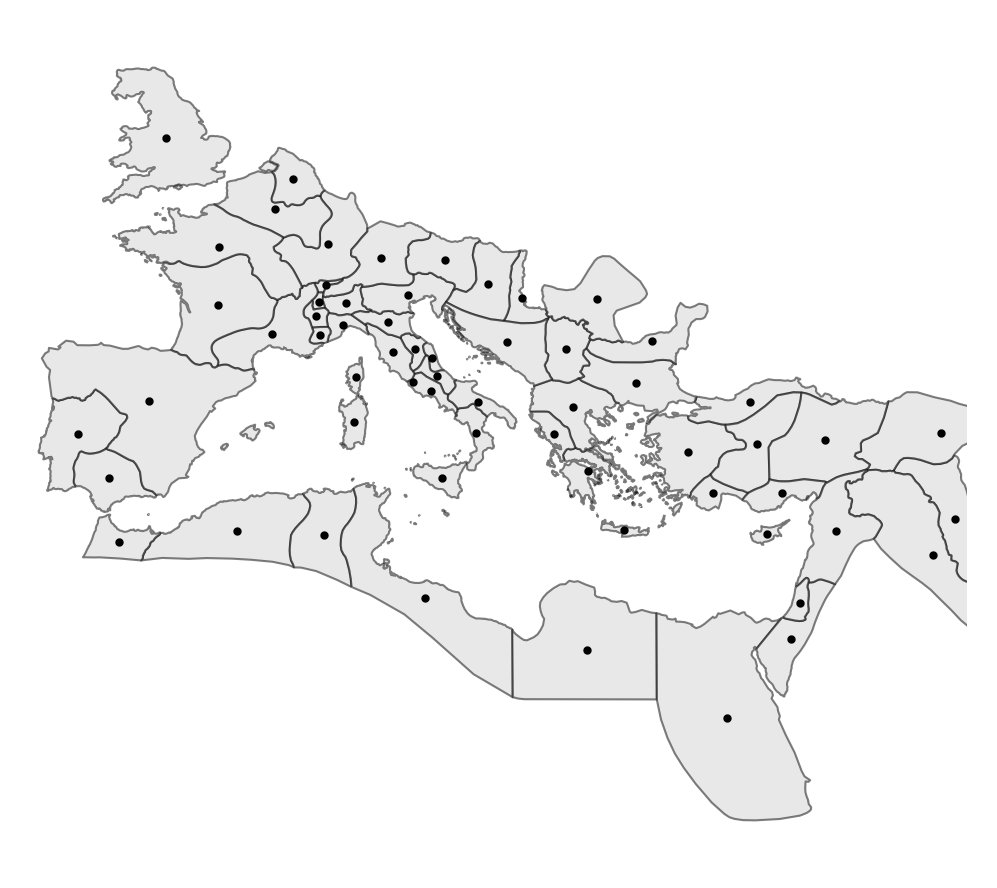

In [29]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
provinces.plot(color="lightgray", ax=ax, alpha=0.5,  edgecolor="black", linewidth=0.5)
centroid_series.plot(markersize=1, color="black", ax=ax)
ax.set_xlim(-10, 45)
ax.set_axis_off()

In [30]:
G = gnx.GeoDiGraph()

In [31]:
G.add_nodes_from_gdf(provinces)

In [32]:
G.nodes(data=True)

NodeDataView({0: {'geometry': <shapely.geometry.multipolygon.MultiPolygon object at 0x17f173310>, 'province': 'Achaia'}, 1: {'geometry': <shapely.geometry.polygon.Polygon object at 0x17f1736a0>, 'province': 'Alpes Poeninae'}, 2: {'geometry': <shapely.geometry.polygon.Polygon object at 0x17f173160>, 'province': 'Alpes Graiae'}, 3: {'geometry': <shapely.geometry.polygon.Polygon object at 0x17f173880>, 'province': 'Umbria (Regio VI)'}, 4: {'geometry': <shapely.geometry.polygon.Polygon object at 0x17f173820>, 'province': 'Picenum (Regio V)'}, 5: {'geometry': <shapely.geometry.polygon.Polygon object at 0x17f173070>, 'province': 'Samnium (Regio IV)'}, 6: {'geometry': <shapely.geometry.polygon.Polygon object at 0x17f173460>, 'province': 'Latium et Campania (Regio I)'}, 7: {'geometry': <shapely.geometry.polygon.Polygon object at 0x17f173550>, 'province': 'Etruria (Regio VII)'}, 8: {'geometry': <shapely.geometry.polygon.Polygon object at 0x17f173040>, 'province': 'Transpadana (Regio XI)'}, 9: {

In [33]:
pronvinces_edges_weighted

,source_index,dest_index,weight
0,0.0,0.0,1
1,0.0,6.0,2
2,0.0,20.0,4
3,0.0,23.0,1
4,0.0,24.0,1
...,...,...,...
586,60.0,56.0,3
587,60.0,57.0,1
588,60.0,58.0,3
589,60.0,59.0,1


In [34]:
pronvinces_edges_weighted.to_csv("../data/pronvinces_edges_weighted.csv")

In [35]:
pronvinces_edges_weighted_tuples = [tuple(el) for el in pronvinces_edges_weighted.values.tolist()]
pronvinces_edges_weighted_tuples[:10]

[(0.0, 0.0, 1.0),
 (0.0, 6.0, 2.0),
 (0.0, 20.0, 4.0),
 (0.0, 23.0, 1.0),
 (0.0, 24.0, 1.0),
 (0.0, 28.0, 1.0),
 (0.0, 29.0, 1.0),
 (0.0, 30.0, 4.0),
 (0.0, 39.0, 1.0),
 (0.0, 41.0, 2.0)]

In [36]:
G.add_weighted_edges_from(pronvinces_edges_weighted_tuples)
G.remove_edges_from(nx.selfloop_edges(G))

In [37]:
G.edges(data=True)

OutEdgeDataView([(0, 6.0, {'weight': 2.0}), (0, 20.0, {'weight': 4.0}), (0, 23.0, {'weight': 1.0}), (0, 24.0, {'weight': 1.0}), (0, 28.0, {'weight': 1.0}), (0, 29.0, {'weight': 1.0}), (0, 30.0, {'weight': 4.0}), (0, 39.0, {'weight': 1.0}), (0, 41.0, {'weight': 2.0}), (0, 43.0, {'weight': 1.0}), (0, 56.0, {'weight': 1.0}), (0, 58.0, {'weight': 1.0}), (0, 59.0, {'weight': 1.0}), (0, 60.0, {'weight': 2.0}), (1, 23.0, {'weight': 1.0}), (1, 58.0, {'weight': 1.0}), (1, 59.0, {'weight': 1.0}), (3, 6.0, {'weight': 3.0}), (3, 7.0, {'weight': 1.0}), (3, 23.0, {'weight': 4.0}), (3, 28.0, {'weight': 3.0}), (3, 44.0, {'weight': 2.0}), (3, 56.0, {'weight': 1.0}), (3, 58.0, {'weight': 2.0}), (3, 59.0, {'weight': 2.0}), (3, 60.0, {'weight': 3.0}), (4, 3.0, {'weight': 1.0}), (4, 6.0, {'weight': 2.0}), (4, 20.0, {'weight': 2.0}), (4, 23.0, {'weight': 2.0}), (4, 28.0, {'weight': 3.0}), (4, 42.0, {'weight': 1.0}), (4, 44.0, {'weight': 2.0}), (4, 56.0, {'weight': 1.0}), (4, 58.0, {'weight': 2.0}), (4, 60.0

In [38]:
indegrees = nx.in_degree_centrality(G)

In [39]:
centroid_series_pos = centroid_series.apply(lambda point: (point.x, point.y))

In [40]:
pos_dict = dict(zip(range(len(centroid_series_pos)), centroid_series_pos.tolist()))
pos_dict

{0: (22.745937455678735, 37.88293449986814),
 1: (7.3502528019699716, 46.28082275400978),
 2: (6.936089574726397, 45.52158927224306),
 3: (12.57540342640504, 43.36422703077655),
 4: (13.595846804035473, 42.99114524151195),
 5: (13.890619981523304, 42.158474991497535),
 6: (13.559398412079501, 41.50852910364442),
 7: (11.302168656079369, 43.231435333943),
 8: (8.54253006433644, 45.467563045901976),
 9: (8.353421202663847, 44.4763739571707),
 10: (11.000893039018138, 44.603378611779306),
 11: (6.80535575677571, 44.872877972798186),
 12: (7.031725786172907, 44.00683043899889),
 13: (12.160602407499251, 45.83353827161291),
 14: (16.151877146419874, 39.6157851918229),
 15: (14.177160478040552, 37.57898844554503),
 16: (9.031052009998177, 40.08214466546073),
 17: (9.103900564175762, 42.14057971967698),
 18: (16.301758360471204, 41.00382599894712),
 19: (28.58449301261493, 38.76384473724245),
 20: (-2.0212971216897078, 52.903105515524274),
 21: (24.857080449996616, 35.229967338064704),
 22: (

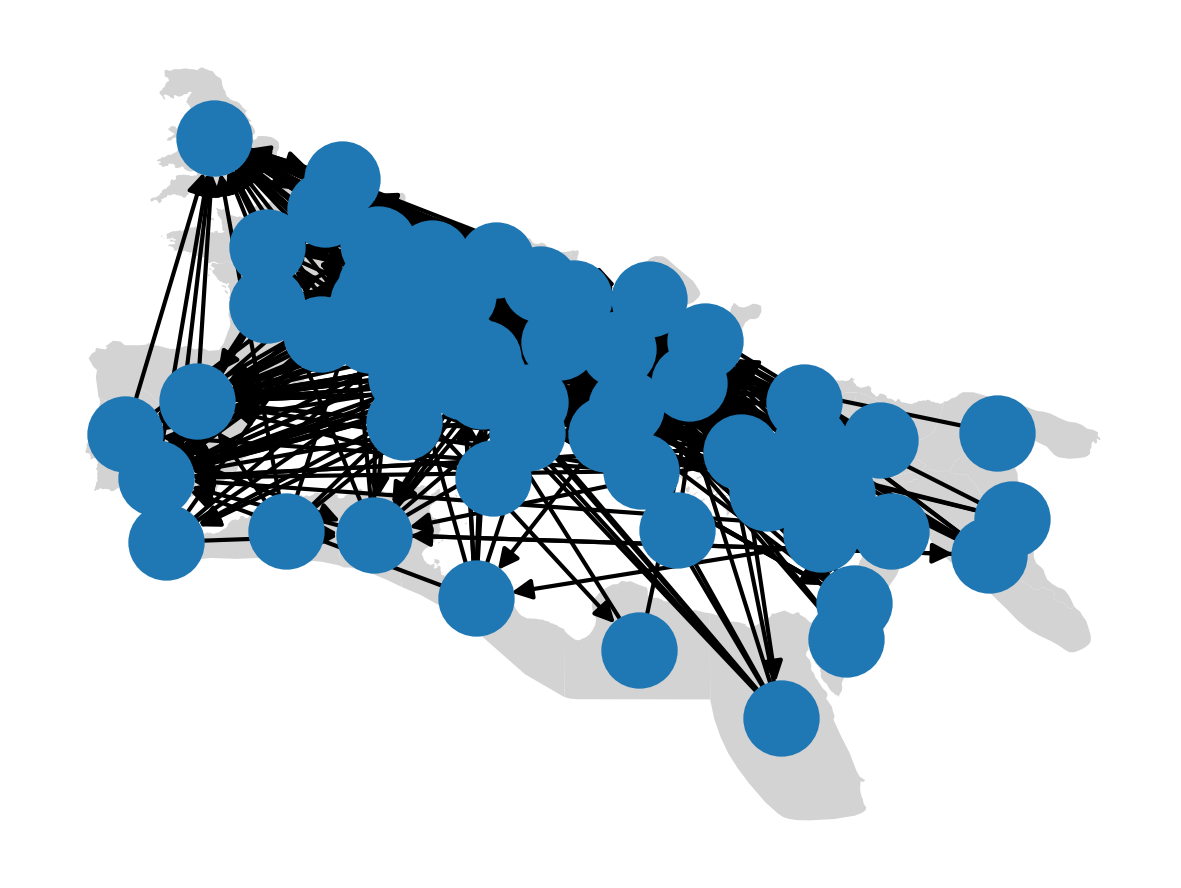

In [42]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
provinces.plot(color="lightgray", ax=ax)
nx.draw(G, pos=pos_dict, ax=ax)

In [43]:
indegrees = nx.in_degree_centrality(G)
node_sizes = list(indegrees.values())

In [44]:
def plot_network(G, edge_width_attr="weight", margins = 0.2, pos=pos_dict, legend_dict=None,ax=None):
    node_colors = ["black" for node in G.nodes()]
    indegrees = nx.in_degree_centrality(G)
    node_sizes = [val *50 for val in  list(indegrees.values())]
    edge_sizes = [np.log2(w*1) for w in nx.get_edge_attributes(G, edge_width_attr).values()]
    if ax == None:
        fig, ax = plt.subplots()
    ax.set_axis_off()
    layer_edges = nx.draw_networkx_edges(G,
                                         pos=pos,
                                         alpha=0.4,
                                         width= edge_sizes,
                                         style="solid",
                                         edge_color="darkblue",
                                         connectionstyle="arc3,rad=0.2",
                                         ax=ax)
    layer_nodes = nx.draw_networkx_nodes(G,
                                         pos=pos,
                                         node_size=node_sizes,
                                         node_color=node_colors,
                                         ax=ax)
    #layer_labels = nx.draw_networkx_labels(H,
    #                                       pos=pos,
    #                                       font_size=8,
    #                                       ax=ax)
    #if legend_dict != None:
    #    markers = [plt.Line2D([0,0],[0,0], marker="o", color=color, lw=0) for color in legend_dict.values()]
    #    ax.legend(markers, legend_dict.keys(), bbox_to_anchor=(0, 0), loc='upper left', frameon=False)
    layers = [layer_edges, layer_nodes] #, layer_labels]
    return

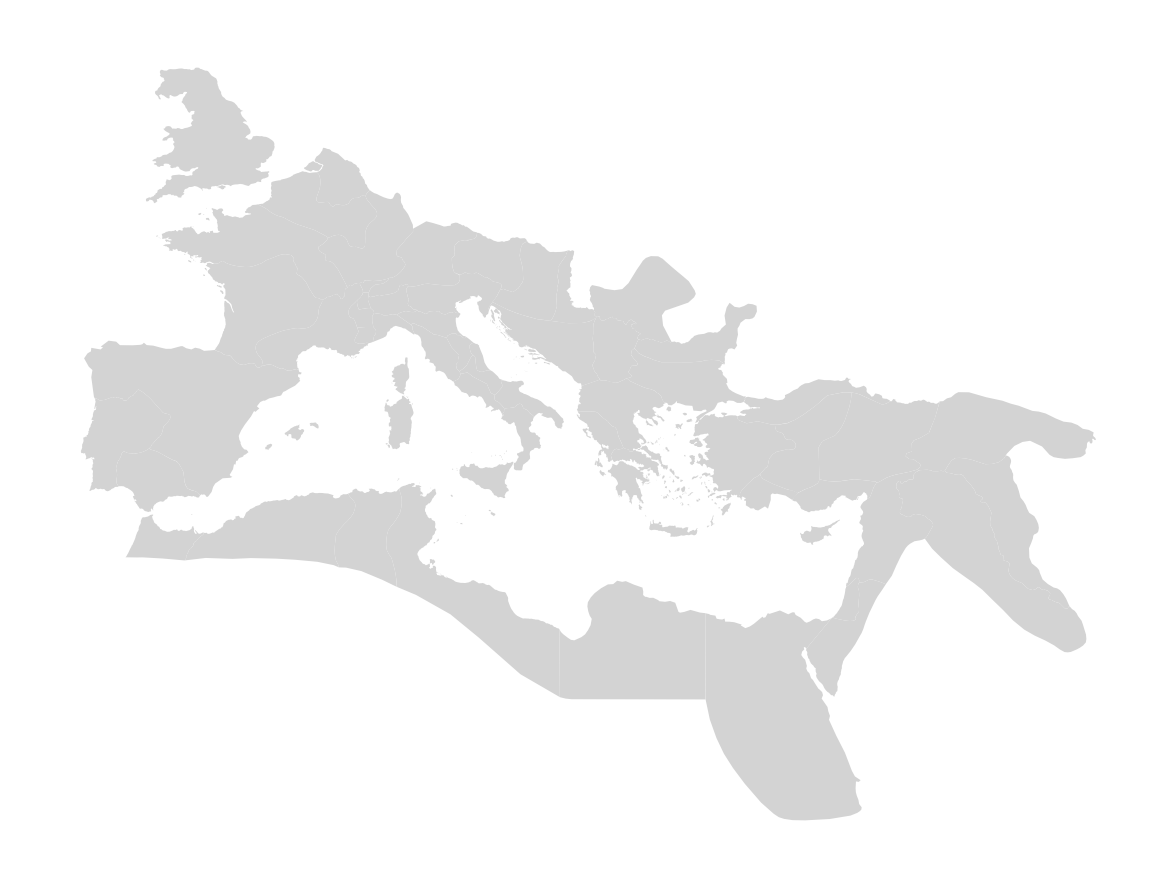

In [214]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
provinces.plot(color="lightgray", ax=ax)
plot_network(G, edge_width_attr="weight", margins = 0.2, pos=pos_dict, ax=ax)

In [52]:
len(indegrees.values())

61

In [59]:
list(indegrees.values())

[0.15,
 0.0,
 0.06666666666666667,
 0.08333333333333333,
 0.016666666666666666,
 0.0,
 0.5333333333333333,
 0.1,
 0.016666666666666666,
 0.0,
 0.11666666666666667,
 0.05,
 0.08333333333333333,
 0.05,
 0.0,
 0.0,
 0.03333333333333333,
 0.0,
 0.0,
 0.0,
 0.5333333333333333,
 0.0,
 0.0,
 0.7333333333333333,
 0.1,
 0.016666666666666666,
 0.0,
 0.08333333333333333,
 0.5333333333333333,
 0.06666666666666667,
 0.26666666666666666,
 0.0,
 0.0,
 0.0,
 0.0,
 0.016666666666666666,
 0.016666666666666666,
 0.0,
 0.03333333333333333,
 0.21666666666666667,
 0.03333333333333333,
 0.3,
 0.36666666666666664,
 0.6166666666666667,
 0.7,
 0.016666666666666666,
 0.016666666666666666,
 0.0,
 0.13333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.26666666666666666,
 0.08333333333333333,
 0.0,
 0.0,
 0.05,
 0.6333333333333333,
 0.4166666666666667,
 0.55,
 0.6166666666666667,
 0.5333333333333333]

In [61]:
cmap = plt.colormaps.get_cmap("Greens")
values = list(indegrees.values())
norm = plt.Normalize(min(values), max(values))
normalized_values = norm(values)
colormap_values = cmap(normalized_values)

In [96]:
[w for w in nx.get_edge_attributes(G, "weight").values()]

[2.0,
 4.0,
 1.0,
 1.0,
 1.0,
 1.0,
 4.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 3.0,
 1.0,
 4.0,
 3.0,
 2.0,
 1.0,
 2.0,
 2.0,
 3.0,
 1.0,
 2.0,
 2.0,
 2.0,
 3.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 8.0,
 2.0,
 1.0,
 2.0,
 2.0,
 5.0,
 7.0,
 2.0,
 2.0,
 1.0,
 1.0,
 8.0,
 2.0,
 3.0,
 3.0,
 3.0,
 1.0,
 3.0,
 1.0,
 1.0,
 3.0,
 6.0,
 2.0,
 2.0,
 4.0,
 1.0,
 4.0,
 2.0,
 1.0,
 4.0,
 1.0,
 13.0,
 3.0,
 1.0,
 3.0,
 3.0,
 28.0,
 4.0,
 3.0,
 1.0,
 1.0,
 2.0,
 6.0,
 5.0,
 1.0,
 2.0,
 8.0,
 3.0,
 3.0,
 6.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 6.0,
 3.0,
 1.0,
 9.0,
 3.0,
 12.0,
 6.0,
 4.0,
 2.0,
 8.0,
 1.0,
 4.0,
 1.0,
 15.0,
 9.0,
 2.0,
 1.0,
 1.0,
 1.0,
 3.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 4.0,
 3.0,
 1.0,
 1.0,
 11.0,
 1.0,
 6.0,
 24.0,
 1.0,
 6.0,
 2.0,
 1.0,
 1.0,
 8.0,
 19.0,
 30.0,
 3.0,
 3.0,
 15.0,
 3.0,
 29.0,
 10.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 4.0,
 2.0,
 1.0,
 1.0,
 1.0,
 3.0,
 2.0,
 4.0,

In [98]:
nx.get_edge_attributes(G, "weight")

{(0, 6.0): 2.0,
 (0, 20.0): 4.0,
 (0, 23.0): 1.0,
 (0, 24.0): 1.0,
 (0, 28.0): 1.0,
 (0, 29.0): 1.0,
 (0, 30.0): 4.0,
 (0, 39.0): 1.0,
 (0, 41.0): 2.0,
 (0, 43.0): 1.0,
 (0, 56.0): 1.0,
 (0, 58.0): 1.0,
 (0, 59.0): 1.0,
 (0, 60.0): 2.0,
 (1, 23.0): 1.0,
 (1, 58.0): 1.0,
 (1, 59.0): 1.0,
 (3, 6.0): 3.0,
 (3, 7.0): 1.0,
 (3, 23.0): 4.0,
 (3, 28.0): 3.0,
 (3, 44.0): 2.0,
 (3, 56.0): 1.0,
 (3, 58.0): 2.0,
 (3, 59.0): 2.0,
 (3, 60.0): 3.0,
 (4, 3.0): 1.0,
 (4, 6.0): 2.0,
 (4, 20.0): 2.0,
 (4, 23.0): 2.0,
 (4, 28.0): 3.0,
 (4, 42.0): 1.0,
 (4, 44.0): 2.0,
 (4, 56.0): 1.0,
 (4, 58.0): 2.0,
 (4, 60.0): 2.0,
 (5, 6.0): 2.0,
 (5, 23.0): 1.0,
 (5, 44.0): 2.0,
 (5, 60.0): 2.0,
 (6, 2.0): 1.0,
 (6, 12.0): 1.0,
 (6, 20.0): 1.0,
 (6, 23.0): 8.0,
 (6, 28.0): 2.0,
 (6, 30.0): 1.0,
 (6, 39.0): 2.0,
 (6, 41.0): 2.0,
 (6, 42.0): 5.0,
 (6, 43.0): 7.0,
 (6, 44.0): 2.0,
 (6, 48.0): 2.0,
 (6, 50.0): 1.0,
 (6, 55.0): 1.0,
 (6, 56.0): 8.0,
 (6, 57.0): 2.0,
 (6, 58.0): 3.0,
 (6, 59.0): 3.0,
 (6, 60.0): 3.0,
 (7,

In [107]:
def plot_network(G, edge_width_attr="weight", margins = 0.2, pos=pos_dict, legend_dict=None,ax=None):
    node_colors = ["black" for node in G.nodes()]
    indegrees = nx.in_degree_centrality(G)
    cmap = plt.colormaps.get_cmap("Greens")
    values = list(indegrees.values())
    norm = plt.Normalize(min(values), max(values))
    normalized_values = norm(values)
    colormap_values = cmap(normalized_values)
    node_sizes = [val *50 for val in  list(indegrees.values())]
    edge_sizes = [w for w in nx.get_edge_attributes(G, edge_width_attr).values()]
    if ax == None:
        fig, ax = plt.subplots()
    ax.set_axis_off()
    layer_edges = nx.draw_networkx_edges(G,
                                         pos=pos,
                                         node_size=0,
                                         alpha=0.4,
                                         width= edge_sizes,
                                         style="solid",
                                         edge_color="lightblue",
                                         arrows=True,
                                         arrowstyle="simple",
                                         arrowsize=5,
                                         connectionstyle="arc3,rad=0.4",
                                         ax=ax)
    #layer_nodes = nx.draw_networkx_nodes(G,
    #                                     pos=pos,
    #                                     node_size=node_sizes,
    #                                     node_color=node_colors,
    #                                     ax=ax)
    #layer_labels = nx.draw_networkx_labels(H,
    #                                       pos=pos,
    #                                       font_size=8,
    #                                       ax=ax)
    #if legend_dict != None:
    #    markers = [plt.Line2D([0,0],[0,0], marker="o", color=color, lw=0) for color in legend_dict.values()]
    #    ax.legend(markers, legend_dict.keys(), bbox_to_anchor=(0, 0), loc='upper left', frameon=False)
    layers = [layer_edges]#, layer_nodes] #, layer_labels]
    return

[]

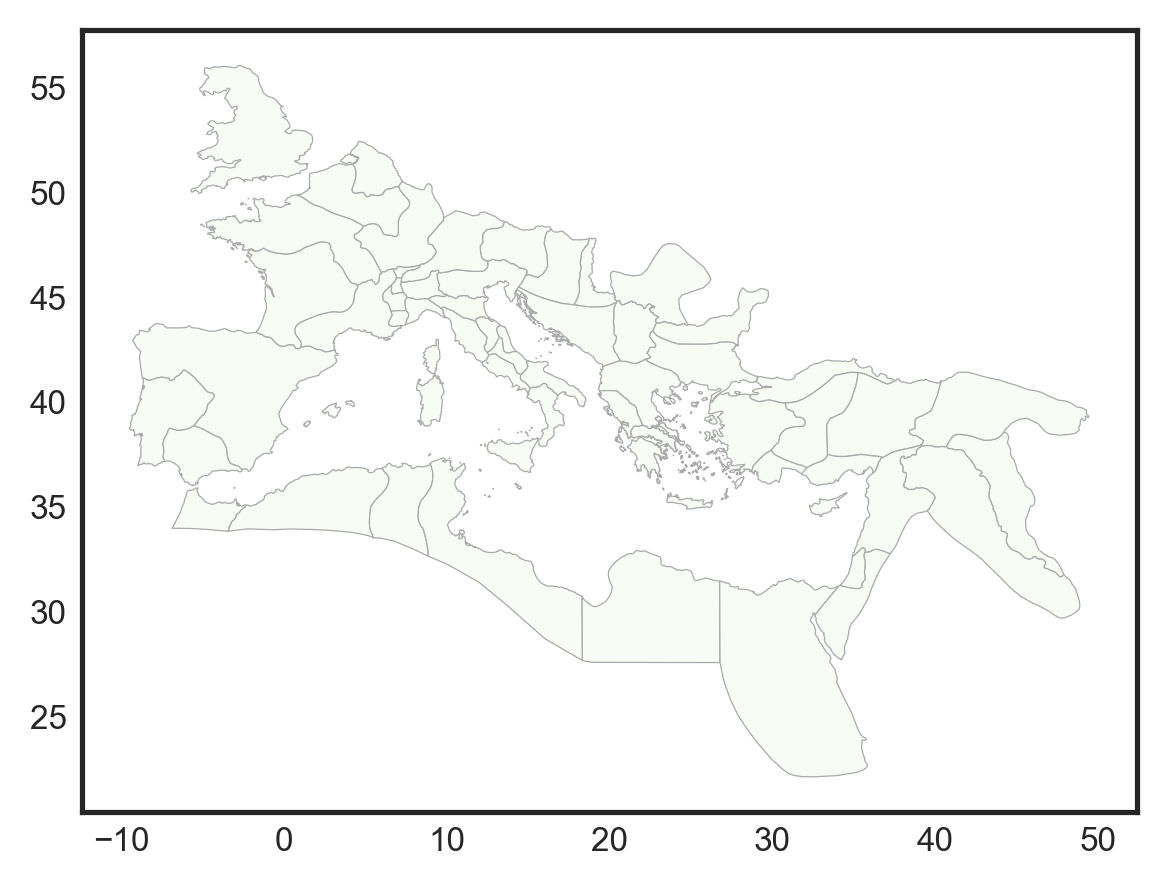

In [213]:
indegrees = nx.in_degree_centrality(G)
cmap = plt.colormaps.get_cmap("Greens")
values = list(indegrees.values())
norm = plt.Normalize(min(values), max(values))
normalized_values = norm(values)
colormap_values = cmap(normalized_values)

fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
provinces.plot(ax=ax, color=colormap_values, edgecolor="darkgray", linewidth=0.3)
edge_sizes = [np.sqrt(w) for w in nx.get_edge_attributes(G, "weight").values()]
nx.draw_networkx_edges(G,
                       pos=pos_dict,
                       node_size=0,
                       alpha=0.4,
                       width= edge_sizes,
                       style="solid",
                       edge_color="gray",
                       arrows=True,
                       connectionstyle="arc3,rad=0.4",
                       ax=ax)

In [115]:
# create an undirected geograph

In [128]:
Gun = gnx.GeoGraph()
Gun.add_nodes_from_gdf(provinces)

In [129]:
for u, v, weight in G.edges(data='weight', default=1):
    if Gun.has_edge(u, v):
        Gun[u][v]['weight'] += weight
    elif Gun.has_edge(v, u):
        Gun[v][u]['weight'] += weight
    else:
        Gun.add_edge(u, v, weight=weight)

In [130]:
Gun.edges(data=True)

EdgeDataView([(0, 6.0, {'weight': 2.0}), (0, 20.0, {'weight': 4.0}), (0, 23.0, {'weight': 1.0}), (0, 24.0, {'weight': 1.0}), (0, 28.0, {'weight': 1.0}), (0, 29.0, {'weight': 1.0}), (0, 30.0, {'weight': 4.0}), (0, 39.0, {'weight': 1.0}), (0, 41.0, {'weight': 2.0}), (0, 43.0, {'weight': 1.0}), (0, 56.0, {'weight': 1.0}), (0, 58.0, {'weight': 1.0}), (0, 59.0, {'weight': 1.0}), (0, 60.0, {'weight': 2.0}), (0, 8, {'weight': 1.0}), (0, 12, {'weight': 1.0}), (0, 13, {'weight': 1.0}), (0, 18, {'weight': 1.0}), (0, 19, {'weight': 2.0}), (0, 25, {'weight': 1.0}), (0, 36, {'weight': 1.0}), (0, 42, {'weight': 1.0}), (0, 52, {'weight': 1.0}), (1, 23.0, {'weight': 1.0}), (1, 58.0, {'weight': 1.0}), (1, 59.0, {'weight': 1.0}), (2, 6, {'weight': 1.0}), (2, 20, {'weight': 1.0}), (2, 23, {'weight': 2.0}), (2, 24, {'weight': 2.0}), (3, 6.0, {'weight': 3.0}), (3, 7.0, {'weight': 2.0}), (3, 23.0, {'weight': 4.0}), (3, 28.0, {'weight': 3.0}), (3, 44.0, {'weight': 2.0}), (3, 56.0, {'weight': 1.0}), (3, 58.0,

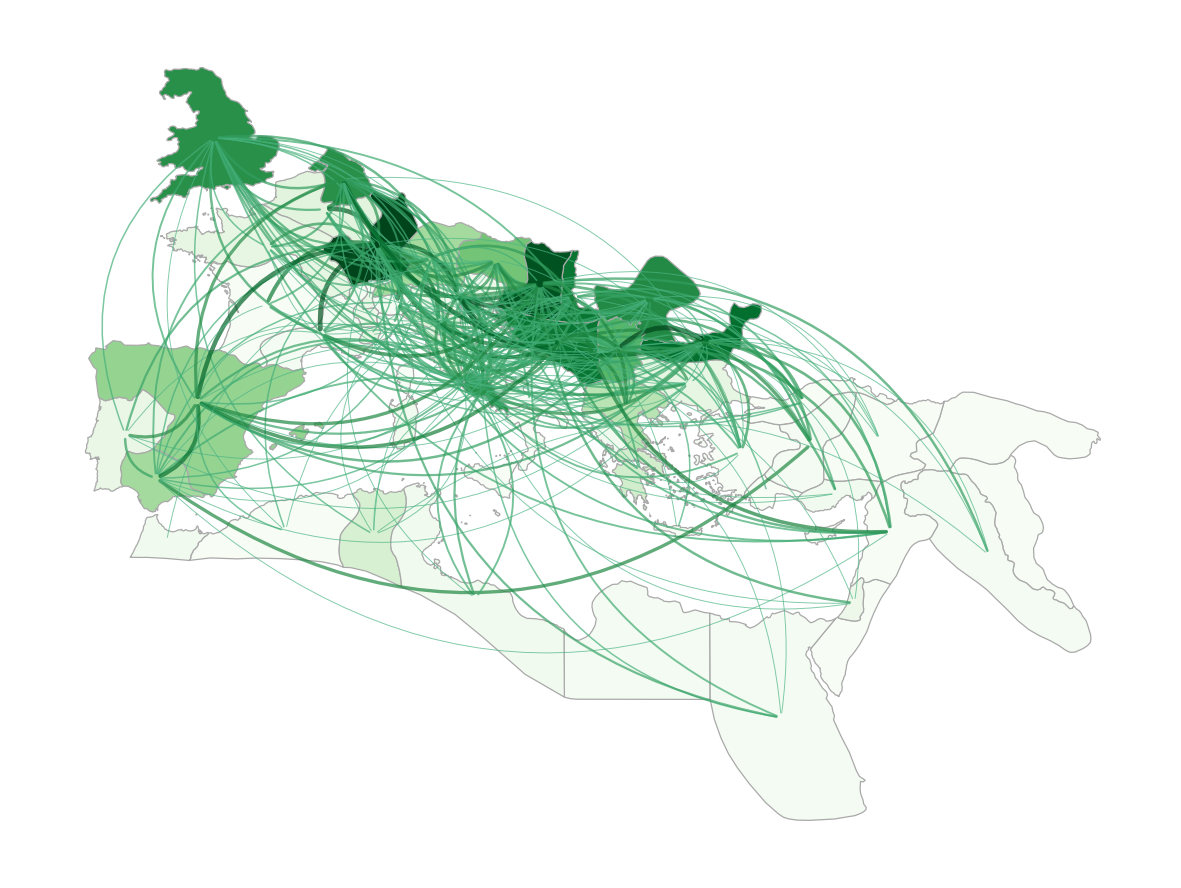

In [157]:
indegrees = nx.in_degree_centrality(G)
cmap = plt.colormaps.get_cmap("Greens")
values = list(indegrees.values())
norm = plt.Normalize(min(values), max(values))
normalized_values = norm(values)
colormap_values = cmap(normalized_values)

fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
provinces.plot(ax=ax, color=colormap_values, edgecolor="darkgray", linewidth=0.3)
edge_sizes = [np.log(w) / 3  for w in nx.get_edge_attributes(Gun, "weight").values()]

edge_weights = [np.sqrt(w) for w in nx.get_edge_attributes(Gun, "weight").values()]
cmap = plt.colormaps.get_cmap("BuGn")
norm = plt.Normalize(min(edge_weights) - max(edge_weights), max(edge_weights))
normalized_edge_weights = norm(edge_weights)
colormap_edge_weights = cmap(normalized_edge_weights)

nx.draw_networkx_edges(Gun,
                       pos=pos_dict,
                       node_size=5,
                       alpha=0.7,
                       width= edge_sizes,
                       #width=0.5,
                       style="solid",
                       edge_color=colormap_edge_weights,
                       arrows=True,
                       connectionstyle="arc3,rad=0.4",
                       ax=ax)
ax.set_axis_off()